In [1]:
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.image as mpimg

In [2]:
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  []


In [3]:
TRAIN_DIR = 'data/train'
VAL_DIR = 'data/validation'

train_muffin_dir = os.path.join(TRAIN_DIR, 'muffin')
train_chihuahua_dir = os.path.join(TRAIN_DIR, 'chihuahua')

val_chihuahua_dir = os.path.join(VAL_DIR, 'chihuahua')
val_muffin_dir = os.path.join(VAL_DIR, 'muffin')

In [4]:
print(f"total training muffin images: {len(os.listdir(train_muffin_dir))}")
print(f"total training chihuahua images: {len(os.listdir(train_chihuahua_dir))}")

total training muffin images: 2174
total training chihuahua images: 2559


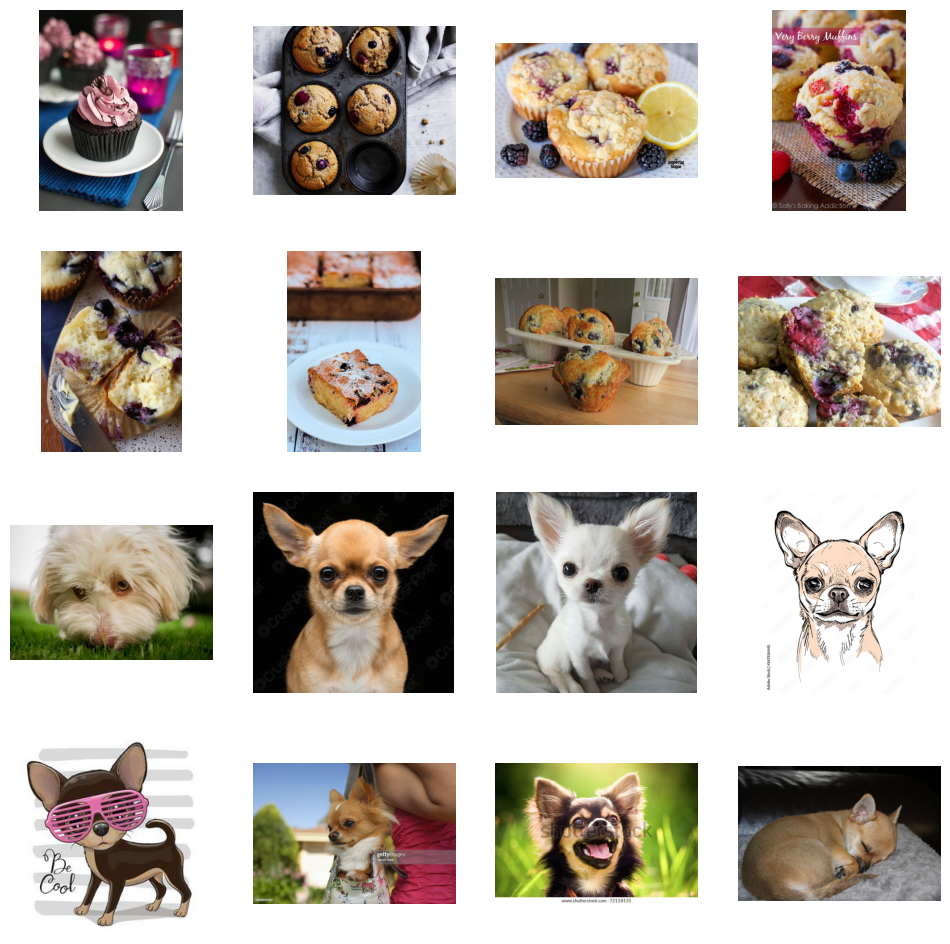

In [7]:
fig = plt.gcf()
fig.set_size_inches(4 * 3, 4 * 3)

muffin_files = os.listdir(train_muffin_dir)
chihuahua_files = os.listdir(train_chihuahua_dir)

next_muffin_pix = [os.path.join(train_muffin_dir, fname)
                   for fname in random.sample(muffin_files, k=8)]
next_chihuahua_pix = [os.path.join(train_chihuahua_dir, fname)
                      for fname in random.sample(chihuahua_files, k=8)]

for i, img_path in enumerate(next_muffin_pix + next_chihuahua_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')  # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [8]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(300,300,3)),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(16,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    return model


In [9]:
BATCH_SIZE = 32
IMAGE_SIZE = (300,300)
LABEL_MODE = 'binary'

train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE
    )

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE
    )

Found 4733 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.


In [10]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (train_dataset
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       )

validation_dataset_final = (validation_dataset
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                            )

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.Input(shape=(300,300,3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2, fill_mode='nearest'),
    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode='nearest'),
    tf.keras.layers.RandomZoom(0.2, fill_mode='nearest')
])

In [12]:
def demo_augmentation(sample_image, model, num_aug):

    image_preview = []

    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    image_preview.append(sample_image_pil)

    for i in range(NUM_AUG):
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    fig, axes = plt.subplots(1, NUM_AUG + 1, figsize=(12, 12))

    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')

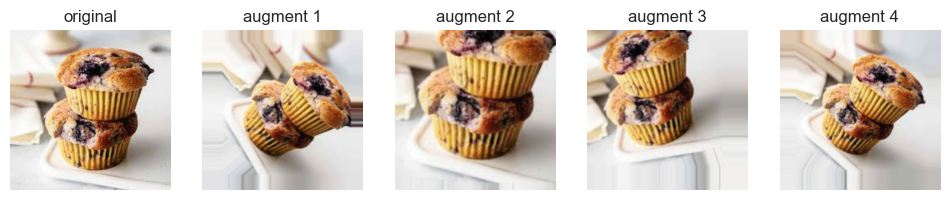

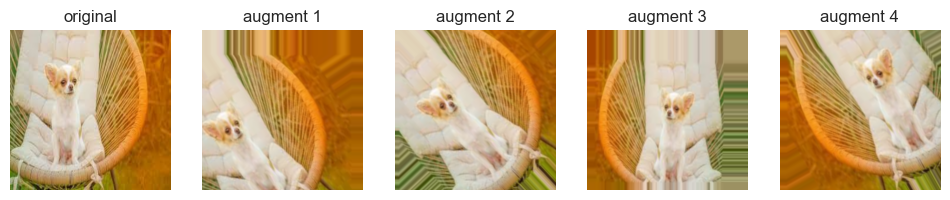

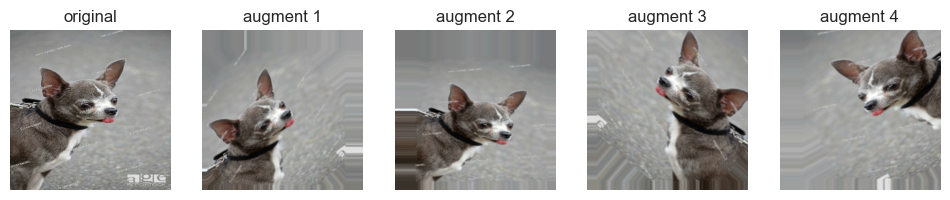

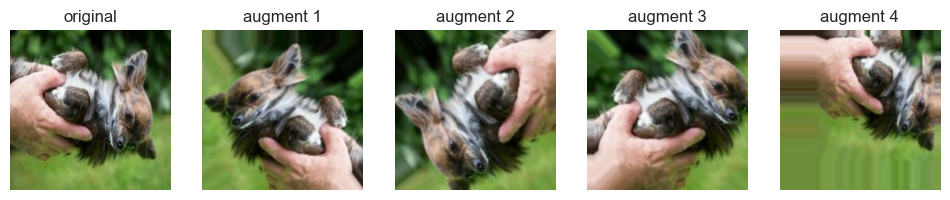

In [13]:
NUM_AUG = 4

sample_batch = list(train_dataset.take(1))[0][0]

demo_augmentation(sample_batch[0], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[1], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[2], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[3], data_augmentation, NUM_AUG)

del sample_batch

In [14]:
model_without_aug = create_model()

model_with_aug = tf.keras.models.Sequential([
    data_augmentation,
    model_without_aug
])

model_with_aug.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

In [15]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self,epoch,logs=None):
        if logs['accuracy'] >= 0.85 and logs['val_accuracy'] >= 0.85:
            self.model.stop_training = True

            print("\nReached 85% train accuracy and 85% validation accuracy, so cancelling training!")


In [16]:
EPOCHS = 10

history = model_with_aug.fit(
      train_dataset_final,
      epochs=EPOCHS,
      verbose=2,
      validation_data = validation_dataset_final,
        callbacks = [EarlyStoppingCallback()])

Epoch 1/10
148/148 - 46s - 313ms/step - accuracy: 0.6516 - loss: 0.6216 - val_accuracy: 0.7019 - val_loss: 0.5465
Epoch 2/10
148/148 - 36s - 242ms/step - accuracy: 0.7207 - loss: 0.5469 - val_accuracy: 0.8041 - val_loss: 0.4625
Epoch 3/10
148/148 - 36s - 241ms/step - accuracy: 0.7522 - loss: 0.5114 - val_accuracy: 0.7796 - val_loss: 0.4692
Epoch 4/10
148/148 - 36s - 241ms/step - accuracy: 0.7784 - loss: 0.4734 - val_accuracy: 0.8438 - val_loss: 0.3670
Epoch 5/10
148/148 - 36s - 241ms/step - accuracy: 0.7986 - loss: 0.4364 - val_accuracy: 0.8497 - val_loss: 0.3377
Epoch 6/10
148/148 - 36s - 241ms/step - accuracy: 0.8124 - loss: 0.4240 - val_accuracy: 0.8277 - val_loss: 0.3962
Epoch 7/10
148/148 - 36s - 244ms/step - accuracy: 0.8221 - loss: 0.4030 - val_accuracy: 0.8260 - val_loss: 0.4116
Epoch 8/10
148/148 - 36s - 244ms/step - accuracy: 0.8284 - loss: 0.3886 - val_accuracy: 0.7905 - val_loss: 0.4821
Epoch 9/10
148/148 - 36s - 242ms/step - accuracy: 0.8390 - loss: 0.3813 - val_accuracy: 

In [17]:
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

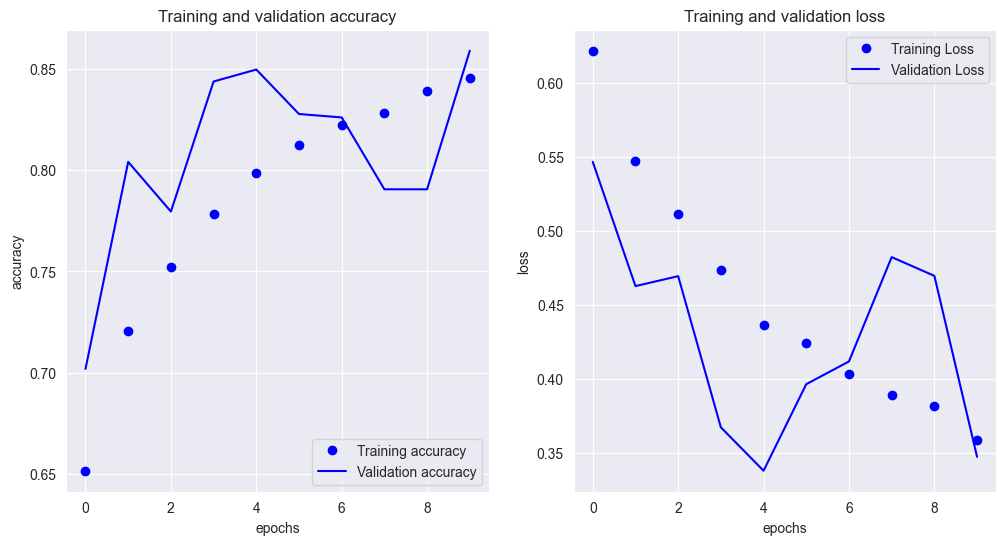

In [18]:
# Plot training results
plot_loss_acc(history)

In [23]:
from ipywidgets import widgets
from io import BytesIO

uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    image = tf.keras.utils.load_img(file, target_size=(300, 300))
    image = tf.keras.utils.img_to_array(image)
    image = np.expand_dims(image, axis=0)

    prediction = model_with_aug.predict(image, verbose=0)[0][0]  # poprawione

    with out:
        if prediction > 0.5:
            print(filename + " is a muffin")
        else:
            print(filename + " is a chihuahua")


def on_upload_change(change):
    with out:
        out.clear_output()

    items = change.new
    for item in items:
        try:
            file_jpgdata = BytesIO(item.content)
            file_predict(item.name, file_jpgdata, out)
        except Exception as e:
            with out:
                print(f"Error processing {item.name}: {e}")



uploader.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()